In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from mplsoccer import PyPizza,add_image,FontManager
from scipy import stats
import math
import matplotlib.pyplot as plt
from urllib.request import urlopen
from PIL import Image
pd.set_option('display.max_columns', None)
from highlight_text import fig_text

### Percentile Rank

In [78]:
df = pd.read_csv('angelino.csv')
params = list(df.iloc[:,1:])
print(params)

['Assist', 'Expected Assist', 'Key Pass', 'Pass into Final 3rd', 'Pass into Pen. Area', 'Cross into Pen. Area', 'Prg. Pass', 'Tackles Won', 'Tackles Defensive 3rd', 'Tackles Middle 3rd', 'Tackless Attack 3rd', 'Dribblers Tackled', 'Interceptions', 'Clearances', 'Touches Defensive 3rd', 'Touches Middle 3rd', 'Touches Attacking 3rd', 'Carries', 'Prg. Carries', 'Carries into Final 3rd', 'Carries into Pen. Area']


In [79]:
df.head()

,Player,Assist,Expected Assist,Key Pass,Pass into Final 3rd,Pass into Pen. Area,Cross into Pen. Area,Prg. Pass,Tackles Won,Tackles Defensive 3rd,Tackles Middle 3rd,Tackless Attack 3rd,Dribblers Tackled,Interceptions,Clearances,Touches Defensive 3rd,Touches Middle 3rd,Touches Attacking 3rd,Carries,Prg. Carries,Carries into Final 3rd,Carries into Pen. Area
0,Angeliño,0.27,0.26,1.72,2.82,1.79,1.00,3.71,0.82,0.65,0.62,0.10,0.79,0.86,2.30,2.68,17.4,26.5,39.3,50.1,0.82,0.89
1,Mitchel Bakker,0.11,0.07,0.92,1.96,0.76,0.11,3.10,0.43,0.49,0.38,0.00,0.33,0.82,1.09,1.74,18.0,31.0,53.8,73.5,1.52,0.92
2,Ridle Baku,0.10,0.17,0.98,4.04,1.29,0.49,4.39,0.91,1.01,0.59,0.14,1.11,0.73,2.06,2.79,18.2,30.7,44.3,83.0,1.74,0.80
3,Ramy Bensebaini,0.04,0.10,0.54,2.93,1.09,0.11,3.66,0.76,0.76,0.36,0.11,0.94,1.30,3.55,5.00,24.8,31.5,50.0,72.9,1.45,0.87
4,Cédric Brunner,0.00,0.09,0.78,1.79,1.01,0.70,3.00,1.05,1.01,0.43,0.08,1.17,1.67,3.07,4.12,20.4,23.7,6.7,56.5,1.25,1.25


In [80]:
angelino = df[df['Player']=='Angeliño']
angelino = angelino.iloc[:,1:].values.tolist()[0]
print(angelino)

[0.27, 0.26, 1.72, 2.82, 1.79, 1.0, 3.71, 0.82, 0.65, 0.62, 0.1, 0.79, 0.86, 2.3, 2.68, 17.4, 26.5, 39.3, 50.1, 0.82, 0.89]


In [81]:
values = []
for x in range(len(params)):
    values.append(math.floor(stats.percentileofscore(df[params[x]],angelino[x])))

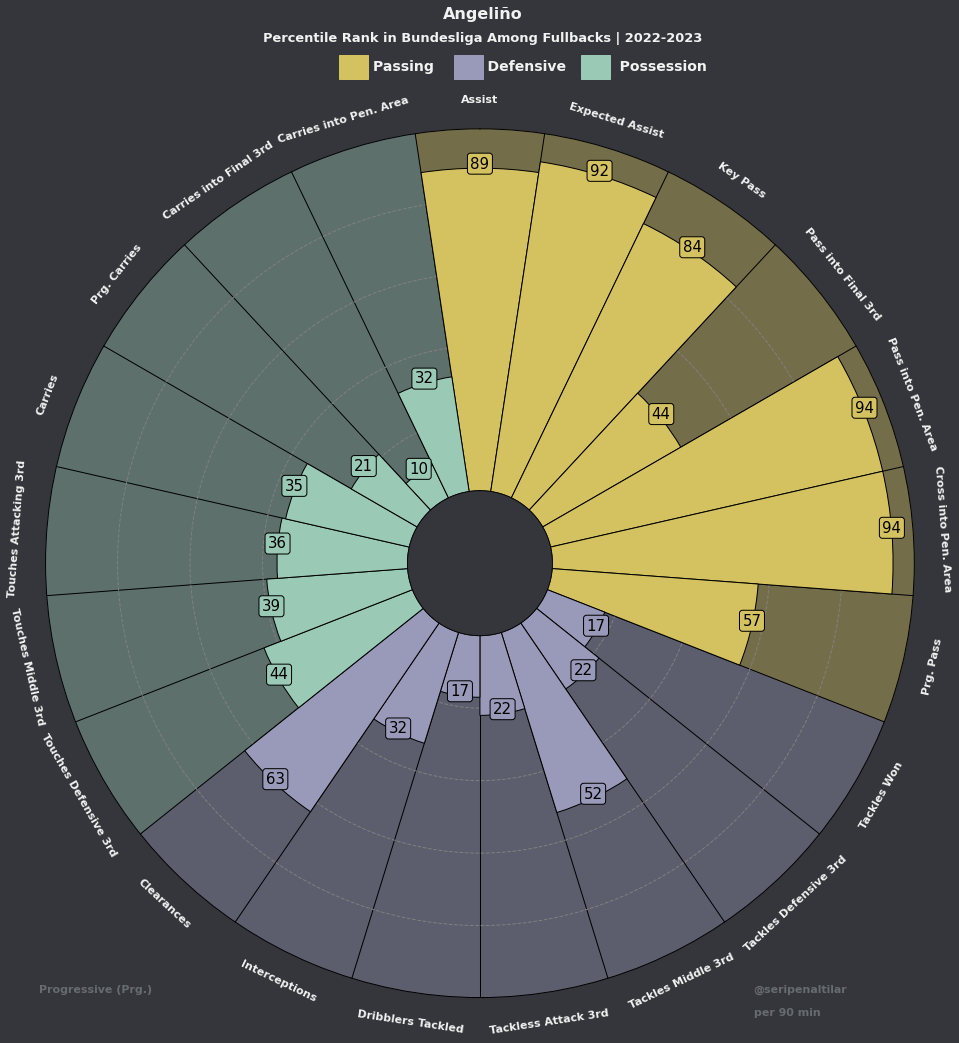

In [82]:
# color for the slices and text
slice_colors = ["#d4c15f"] * 7 + ["#999ab9"] * 7 + ["#9ac9b6"] * 7
text_colors = ["#000000"] * 21

# instantiate PyPizza class
baker = PyPizza(
    params=params,                  # list of parameters
    background_color="#35363b",     # background color #003f5c
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_color="#000000",    # color for last line
    last_circle_lw=2,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    inner_circle_size=20            # size of inner circle
)

# plot pizza
fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(16, 16),                # adjust the figsize according to your need
    color_blank_space="same",        # use the same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#000000", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices
    kwargs_params=dict(
        color="#F2F2F2", fontsize=11, va="center" , weight='bold',
    ),                               # values to be used when adding parameter labels
    kwargs_values=dict(
        color="#F2F2F2", fontsize=15,zorder=3,
        bbox=dict(
            edgecolor="#000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                                
)

# add title
fig.text(
    0.515, 0.975, "Angeliño", size=16,
    ha="center", color="#F2F2F2",fontweight='bold'
)

# add subtitle
fig.text(
    0.515, 0.955,
    "Percentile Rank in Bundesliga Among Fullbacks | 2022-2023",
    size=13,
    ha="center", color="#F2F2F2", fontweight='bold'
)

# add text
fig.text(
    0.42, 0.93, "Passing           Defensive           Possession", size=14,
    color="#F2F2F2", fontweight='bold'
)

fig.text(
    0.75, 0.13, "@seripenaltilar", size=11,
    color="#676c70",fontweight='bold'
)

fig.text(
    0.13, 0.13, "Progressive (Prg.)", size=11,
    color="#676c70",fontweight='bold'
)

fig.text(
    0.75, 0.11, "per 90 min", size=11,
    color="#676c70",fontweight='bold'
)

# add rectangles
fig.patches.extend([
    plt.Rectangle(
        (0.39, 0.9225), 0.025, 0.021, fill=True, color="#d4c15f",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.49, 0.9225), 0.025, 0.021, fill=True, color="#999ab9",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.60, 0.9225), 0.025, 0.021, fill=True, color="#9ac9b6",
        transform=fig.transFigure, figure=fig
    ),
])

# add image
#ax_image = add_image(
    #image, fig, left=0.4615, bottom=0.45, width=0.10, height=0.13
#)

plt.show()

### Comparison Percentile Rank

In [317]:
df = pd.read_csv('uel.csv')

In [318]:
df.drop(df.tail(1).index,inplace=True)

In [319]:
df = df[[ 'Squad',
'Touches in Attacking Third',
'Progressive Passes',
'Tackles in Attacking Third',
'Progressive Passing Dist.',
'Carries into Penalty Area',
'Passes into Penalty Area',
'Crosses into Penalty Area',
'npxG',
'Expected Assist',
'Touches in Penalty Area',
'Interceptions',
'npxG per Shot',
'Progressive Carries',
'Carries into Final Third',
'Total Passing Dist.',
'Passes into Final Third',
'Shots',
'Key Passes'
    ]]

In [320]:
params = list(df.iloc[:,1:])
print(params)

['Touches in Attacking Third', 'Progressive Passes', 'Tackles in Attacking Third', 'Progressive Passing Dist.', 'Carries into Penalty Area', 'Passes into Penalty Area', 'Crosses into Penalty Area', 'npxG', 'Expected Assist', 'Touches in Penalty Area', 'Interceptions', 'npxG per Shot', 'Progressive Carries', 'Carries into Final Third', 'Total Passing Dist.', 'Passes into Final Third', 'Shots', 'Key Passes']


In [321]:
fb = df[df['Squad']=='Fenerbahçe']
#fb = df[df['Squad']=='Arsenal']
fb = fb.iloc[:,1:].values.tolist()[0]
print(fb)

[167.2, 43.3, 3.17, 2758.7, 5.0, 10.7, 1.67, 1.38, 1.05, 26.5, 9.5, 0.12, 15.5, 13.3, 7828.2, 34.3, 11.67, 8.0]


In [322]:
ts = df[df['Squad']=='Trabzonspor']
#ts = df[df['Squad']=='Manchester Utd']
ts = ts.iloc[:,1:].values.tolist()[0]
print(ts)

[163.0, 41.5, 2.17, 2634.8, 4.67, 7.0, 1.5, 1.0, 0.82, 18.3, 6.33, 0.06, 15.5, 15.2, 8545.0, 37.7, 16.0, 13.3]


In [323]:
fb_v = []
for x in range(len(params)):
    fb_v.append(math.floor(stats.percentileofscore(df[params[x]],fb[x])))

In [324]:
ts_v = []
for x in range(len(params)):
    ts_v.append(math.floor(stats.percentileofscore(df[params[x]],ts[x])))

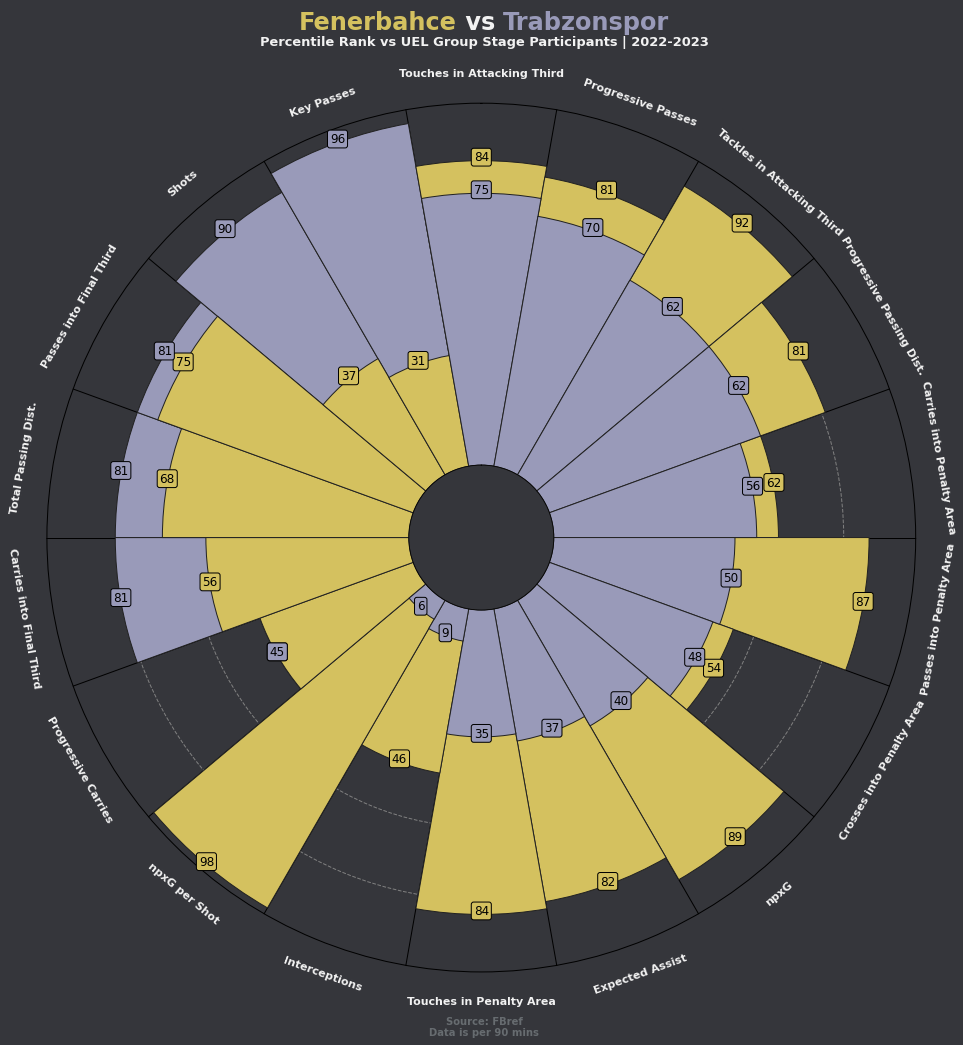

In [325]:
# parameter and values list
# The values are taken from the excellent fbref website (supplied by StatsBomb)


# instantiate PyPizza class
# instantiate PyPizza class
baker = PyPizza(
    params=params,                  # list of parameters
    background_color="#35363b",     # background color #003f5c
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_color="#000000",    # color for last line
    last_circle_lw=2,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    inner_circle_size=20            # size of inner circle
)

# plot pizza
fig, ax = baker.make_pizza(
    fb_v,                     # list of values
    compare_values=ts_v,    # comparison values
    figsize=(16, 16),             # adjust figsize according to your need
    kwargs_slices=dict(
        facecolor="#d4c15f", edgecolor="#222222",
        zorder=2, linewidth=1
    ),                          # values to be used when plotting slices
    kwargs_compare=dict(
        facecolor="#999ab9", edgecolor="#222222",
        zorder=2, linewidth=1,
    ),
    kwargs_params=dict(
        color="#F2F2F2", fontsize=11, va="center", weight='bold'
    ),                          # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="#d4c15f",
            boxstyle="round,pad=0.2", lw=1
        )
    ),                          # values to be used when adding parameter-values labels
    kwargs_compare_values=dict(
        color="#000000", fontsize=12, zorder=3,
        bbox=dict(edgecolor="#000000", facecolor="#999ab9", boxstyle="round,pad=0.2", lw=1)
    ),                          # values to be used when adding parameter-values labels
)

# add title
fig_text(
    0.515, 0.96, "<Fenerbahce> vs <Trabzonspor>", size=24, fig=fig,
    highlight_textprops=[{"color": '#d4c15f'}, {"color": '#999ab9'}],
    ha="center", color="#F2F2F2", fontweight='bold'
)

fig.text(
    0.515, 0.93,
    "Percentile Rank vs UEL Group Stage Participants | 2022-2023",
    size=13,
    ha="center", color="#F2F2F2", fontweight='bold'
) 

fig.text(
    0.515, 0.07, "Source: FBref\nData is per 90 mins", size=10,
    ha="center", color="#676c70",fontweight='bold'
)

plt.show()

In [297]:
df.columns

Index(['Squad', 'Touches in Attacking Third', 'Progressive Passes',
       'Tackles in Attacking Third', 'Progressive Passing Dist.',
       'Carries into Penalty Area', 'Passes into Penalty Area',
       'Crosses into Penalty Area', 'npxG', 'Expected Assist',
       'Touches in Penalty Area', 'Interceptions', 'npxG per Shot',
       'Progressive Carries', 'Carries into Final Third',
       'Total Passing Dist.', 'Passes into Final Third', 'Shots',
       'Key Passes'],
      dtype='object')

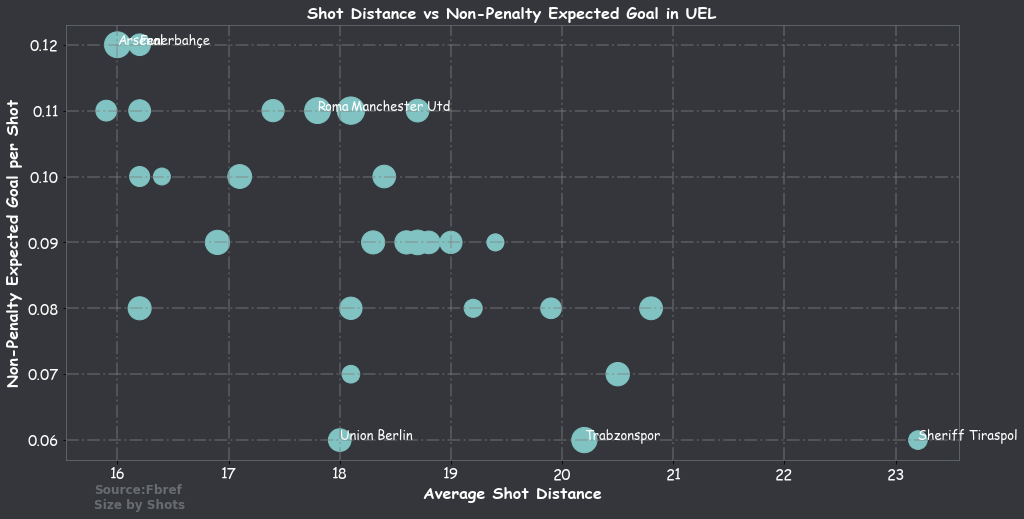

In [305]:
# creating scatter
fig,ax = plt.subplots(figsize=(16,8))
fig.patch.set_facecolor('#35363b')

ax.scatter(df['Dist'],df['npxG per Shot'],c='#80c3c2',s=df['Shots']*40)


ax.set_facecolor(color='#35363b')
ax.spines[['left','bottom','right','top']].set_color('#676c70')
ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 2,
            alpha = 0.4)

font = {'family': 'Comic Sans MS',
       'color': 'white',
       'weight': 'bold',
       'size': 16
       }

teams = ['Arsenal','Fenerbahçe','Manchester Utd','Trabzonspor','Union Berlin','Roma','Sheriff Tiraspol']
for x in teams:
    ax.annotate(x,(df[df['Squad']==x]['Dist'],
                   df[df['Squad']==x]['npxG per Shot']),c='white',size=13,family='Comic Sans MS')


ax.set_xlabel('Average Shot Distance', fontdict=font)
ax.set_ylabel('Non-Penalty Expected Goal per Shot', fontdict=font)
plt.xticks(fontsize=15,c='white',family='Comic Sans MS')
plt.yticks(fontsize=15,c='white',family='Comic Sans MS')


plt.title("Shot Distance vs Non-Penalty Expected Goal in UEL",fontdict=font)
#plt.figtext(0.80,0.06,"@seripenaltilar",fontsize=12,fontweight='bold',color='#676c70')
plt.figtext(0.15,0.04,"Source:Fbref\nSize by Shots",fontsize=12,fontweight='bold',color='#676c70')


plt.show()